In [79]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math



In [80]:
stock_data = pd.read_csv(
    'D:/Project/StockPrediction/zomato_dataset.csv', 
    index_col='Date', 
    parse_dates=['Date'], 
    date_parser=lambda dates: pd.to_datetime(dates, format='%d-%m-%Y')  ).fillna(0)
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-07-23,116.000000,138.899994,115.000000,126.000000,126.000000,694895290
2021-07-26,126.349998,143.750000,125.300003,140.649994,140.649994,249723854
2021-07-27,141.699997,147.800003,127.750000,132.899994,132.899994,240341900
2021-07-28,131.000000,135.000000,123.550003,131.199997,131.199997,159793731
2021-07-29,134.949997,144.000000,132.199997,141.550003,141.550003,117973089
...,...,...,...,...,...,...
2024-05-15,188.800003,193.399994,183.149994,192.000000,192.000000,44772997
2024-05-16,192.899994,195.850006,189.000000,195.199997,195.199997,35478593
2024-05-17,195.149994,196.000000,193.100006,194.850006,194.850006,20841351


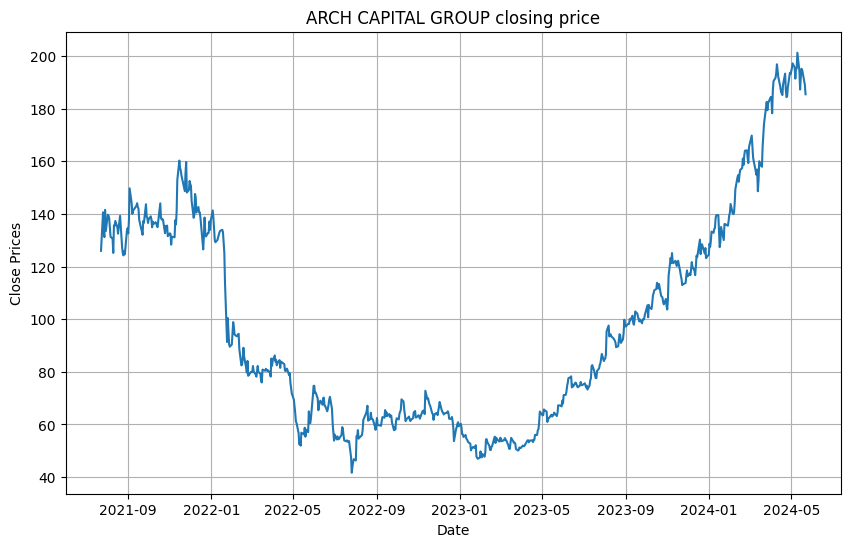

In [81]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('ARCH CAPITAL GROUP closing price')
plt.show()

<Axes: ylabel='Density'>

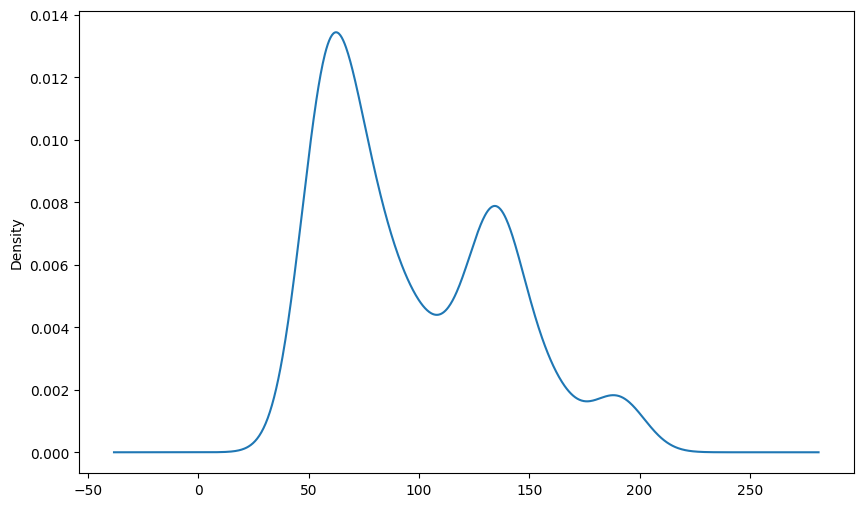

In [82]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

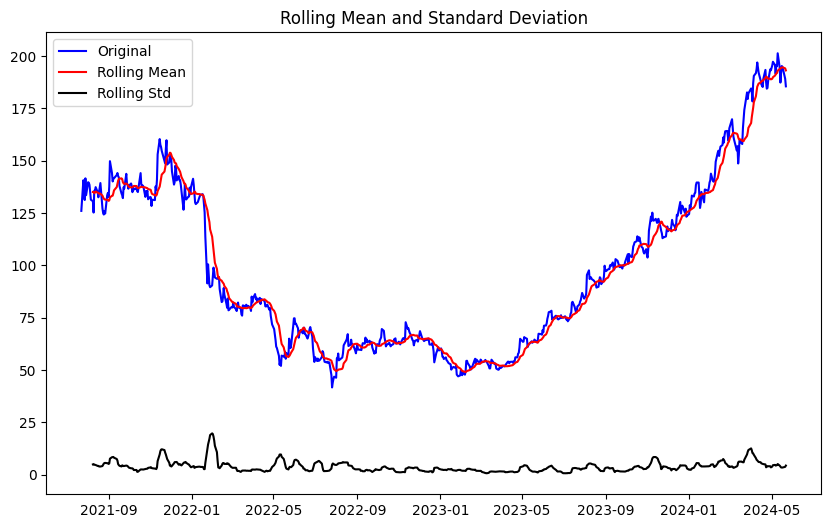

Results of dickey fuller test
Test Statistics                 -0.055583
p-value                          0.953687
No. of lags used                 0.000000
Number of observations used    697.000000
critical value (1%)             -3.439767
critical value (5%)             -2.865696
critical value (10%)            -2.568983
dtype: float64


In [83]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(df_close)

<Axes: ylabel='Density'>

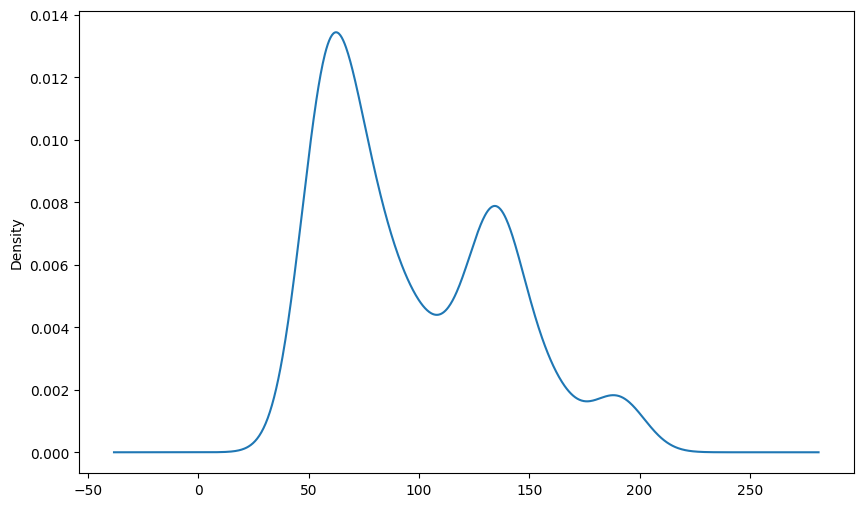

In [84]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

<Figure size 1000x600 with 0 Axes>

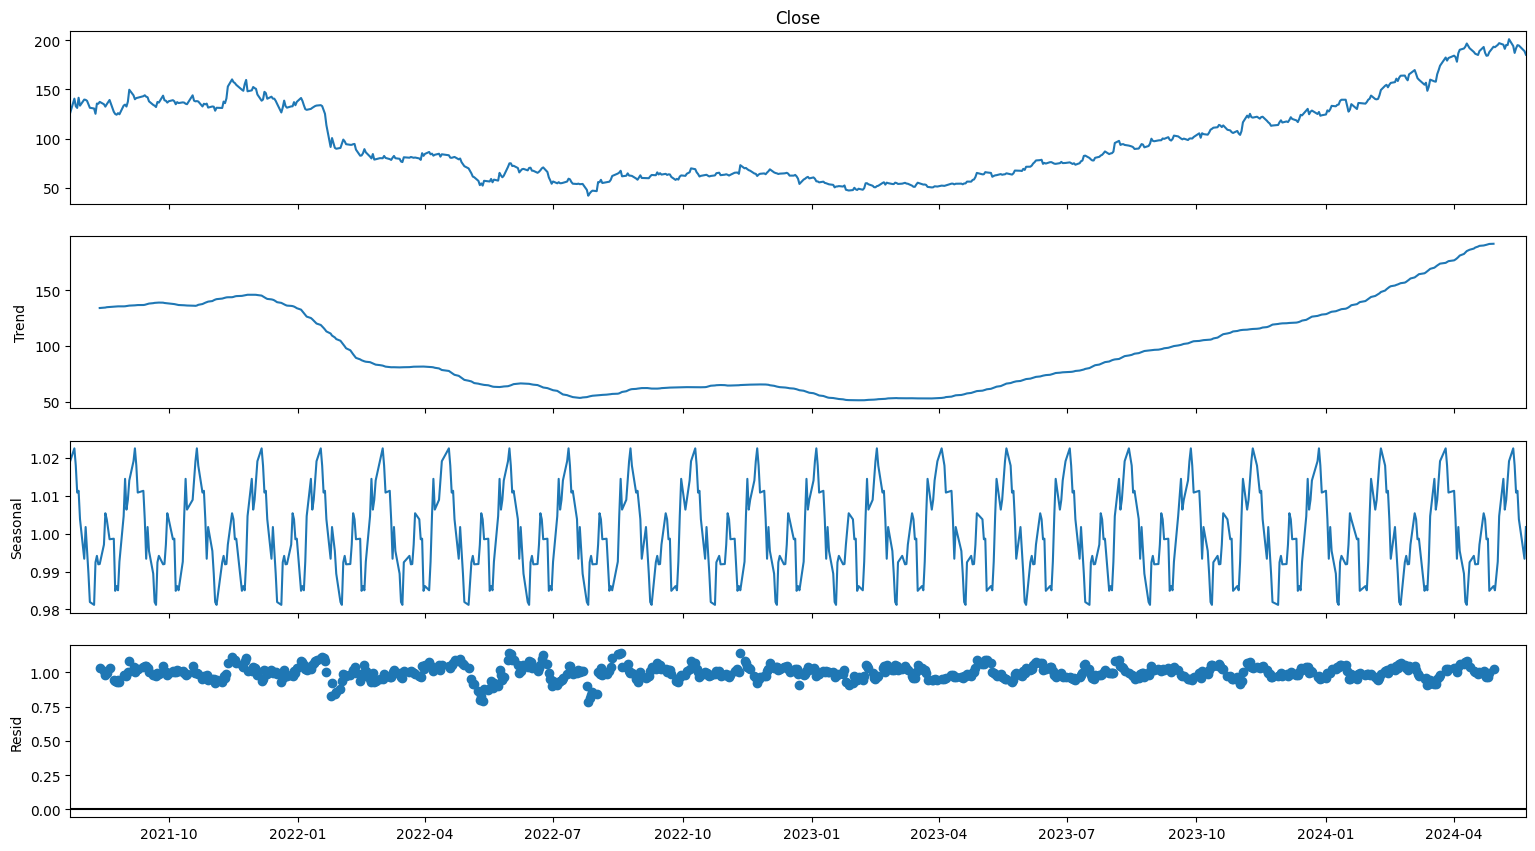

In [85]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

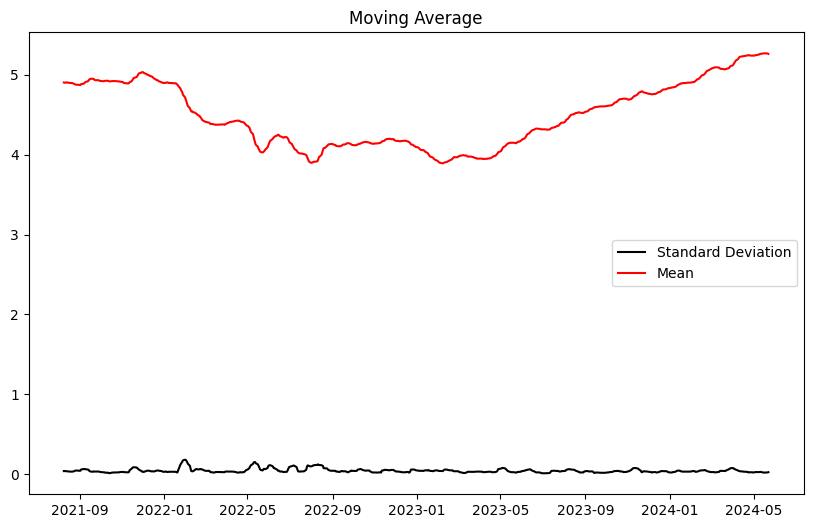

In [86]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

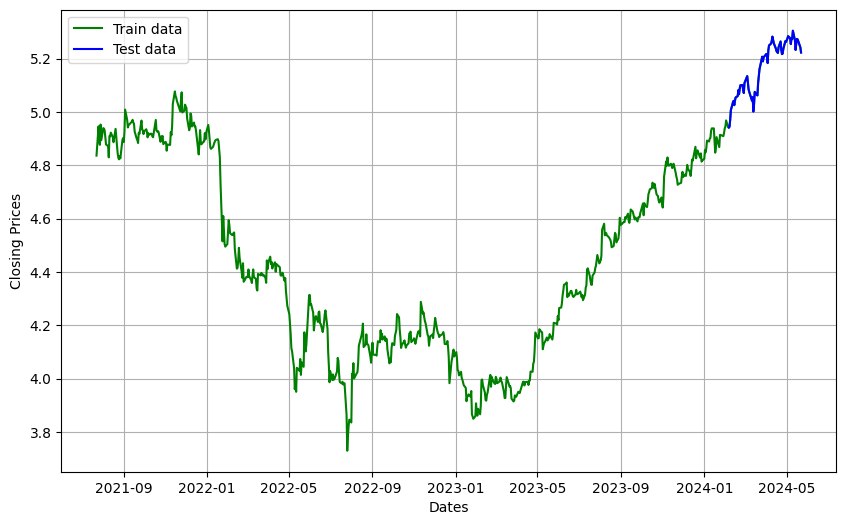

In [107]:
#Train model
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-2442.790, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-2440.790, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-2440.790, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-2444.783, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-2438.790, Time=0.25 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.590 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  625
Model:               SARIMAX(0, 1, 0)   Log Likelihood                1223.392
Date:                Fri, 20 Dec 2024   AIC                          -2444.783
Time:                        12:55:13   BIC                          -2440.347
Sample:                             0   HQIC                         -2443.060
                                - 625                                  

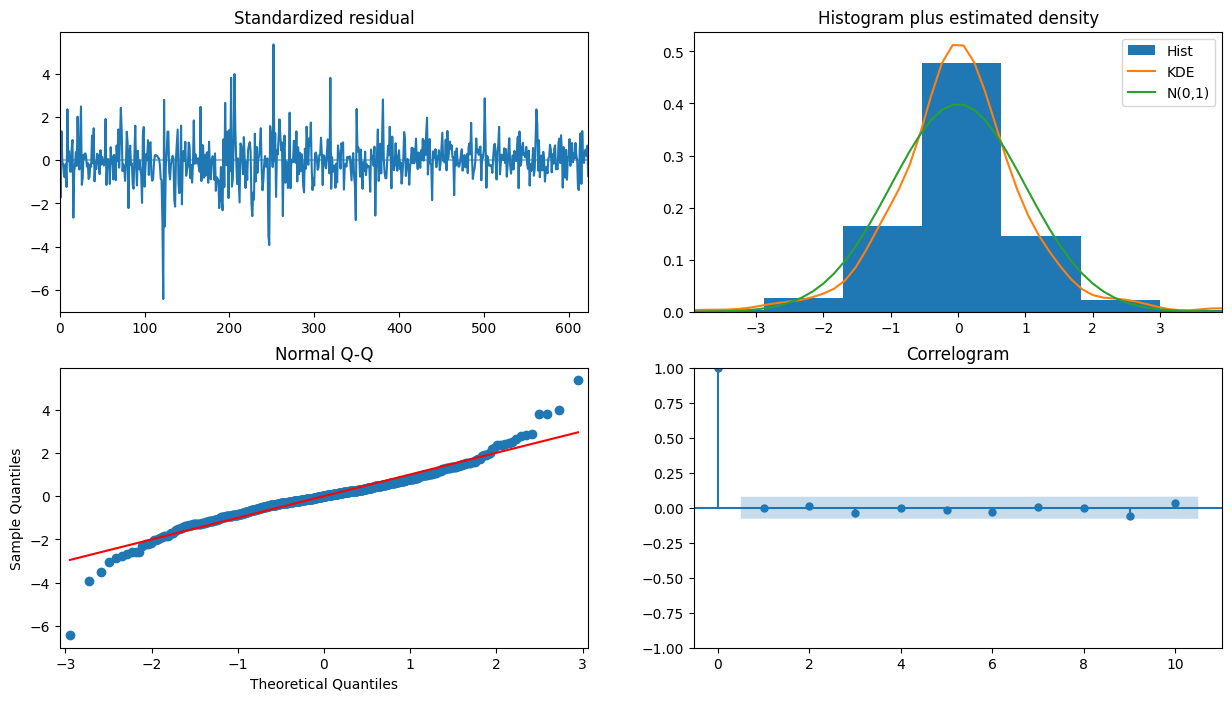

In [108]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [110]:
#As a result, the Auto ARIMA model assigned the values 1, 1, and 2 to, p, d, and q, respectively.

#Modeling
# Build Model
model = ARIMA(train_data, order=(1,1,2))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  625
Model:                 ARIMA(1, 1, 2)   Log Likelihood                1223.449
Date:                Fri, 20 Dec 2024   AIC                          -2438.898
Time:                        12:55:34   BIC                          -2421.154
Sample:                             0   HQIC                         -2432.003
                                - 625                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1169      2.729     -0.043      0.966      -5.465       5.231
ma.L1          0.1178      2.729      0.043      0.966      -5.232       5.467
ma.L2          0.0137      0.035      0.388      0.6

In [120]:
# Forecast
fc, se, conf = fitted.forecast(321, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training data')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title(' Zomato Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('zomato Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

ValueError: too many values to unpack (expected 3)

In [106]:

# Calculate accuracy metrics
def calculate_accuracy(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    accuracy = 100 - mape
    
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')
    print(f'Model Accuracy: {accuracy:.2f}%')

# Calculate and print accuracy metrics
calculate_accuracy(test_data, fc_series)



ValueError: Input contains NaN.